In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
excel_file = pd.ExcelFile("Attached.xlsx")

sheet_name = excel_file.sheet_names

male_df = pd.read_excel('Attached.xlsx', sheet_name='Male Fetal Detection Data')
female_df = pd.read_excel('Attached.xlsx', sheet_name='Female Fetal Detection Data')


male_df['Fetal_Sex'] = 'male'# 为男胎数据添加性别标签
female_df['Fetal_Sex'] = 'female'# 为女胎数据添加性别标签
df = pd.concat([male_df, female_df], ignore_index=True)


df['abnormal'] = df['Chromosomal Aneuploidy'].notna().astype(int)
# - 'Chromosomal Aneuploidy'列记录21、18、13号染色体非整倍体异常（如21三体）
# - .notna()：非空值→True（表示存在异常），空值→False（表示正常）
# - .astype(int)：将True转为1（异常），False转为0（正常）

if 'Z-score of Chromosome Y' not in df.columns:
    df['Z-score of Chromosome Y'] = np.nan# 女性无Y染色体，补充该列并填充NaN
if 'Concentration of Chromosome Y' not in df.columns:
    df['Concentration of Chromosome Y'] = np.nan# 同理补充Y染色体浓度列
# 女性胎儿无Y染色体
# 补充这些列并填充NaN，确保男女数据特征列一致

df['Pregnant Woman\'s BMI'] = df['Pregnant Woman\'s BMI'].fillna(
    df['Pregnant Woman\'s BMI'].median())
# 处理BMI缺失值：
# - 女性数据中存在1个BMI缺失，用中位数填充（

def convert_gestational_week(week_str):
    try:
        # 处理格式如"16w+3"（16周+3天）的孕周字符串
        weeks, days = week_str.replace('w', '').split('+')# 移除"w"，按"+"分割周和天
        return float(weeks) + float(days)/7# 转换为十进制周数（如3天=3/7≈0.43周）
    except:
        return np.nan# 格式异常（如"23w"）返回NaN（后续可进一步清洗）

df['Gestational_Week_Decimal'] = df['Gestational Week at Testing'].apply(
    convert_gestational_week)
    # 孕周转换为数值型：



df['Number of Pregnancies'] = pd.to_numeric(df['Number of Pregnancies'], errors='coerce')
df['Number of Pregnancies'] = df['Number of Pregnancies'].clip(upper=3)


def convert_date_to_int(date_val):
    if pd.isna(date_val):
        return 0 # 缺失值返回0
    if isinstance(date_val, datetime):
        return int(date_val.strftime('%Y%m%d'))# datetime格式→YYYYMMDD整数（如20230510）
    if isinstance(date_val, str):
        try:
            # 字符串尝试解析为日期后转整数
            return int(pd.to_datetime(date_val).strftime('%Y%m%d'))
        except:
            # 若已是YYYYMMDD格式字符串，直接转整数
            try:
                return int(date_val)
            except:
                return 0# 无法转换的字符串返回0
    if isinstance(date_val, (int, float)):
        return int(date_val)# 数值型直接转整数
    return 0# 其他情况返回0

df['Last_Menstrual_Period_Int'] = df['Last Menstrual Period'].apply(convert_date_to_int)
df['Test_Date_Int'] = df['Test Date'].apply(convert_date_to_int)
# 日期转换为整数：

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# 筛选所有数值型特征（如X染色体Z值、GC含量、测序读数、BMI等）

exclude_cols = ['Serial Number', 'abnormal', 'Last_Menstrual_Period_Int', 'Test_Date_Int']
num_cols = [col for col in num_cols if col not in exclude_cols]
# 排除无需标准化的列：
# - 'Serial Number'（样本编号，无实际意义）
# - 'abnormal'（目标变量，无需标准化）
# - 转换后的日期列（保留原始量级更有意义）

scaler = StandardScaler()# 初始化标准化器（将数据缩放到均值=0，标准差=1）
df_std = df.copy()
# df_std[num_cols] = scaler.fit_transform(df[num_cols])
# 别标准化


cat_vars = ['IVF Pregnancy', 'Whether the Fetus is Healthy', 'Fetal_Sex']
# 定义需编码的分类变量：
# - 'IVF Pregnancy'（受孕方式：自然受孕/IVF，可能影响胎盘功能及胎儿DNA释放）
# - 'Whether the Fetus is Healthy'（胎儿健康状态，辅助验证异常标签）
# - 'Fetal_Sex'（性别，后续筛选女性样本时使用）

df_processed = pd.get_dummies(df_std, columns=cat_vars, drop_first=True)


df_processed.columns

Index(['Serial Number', 'Pregnant Woman Code', 'Age', 'Height', 'Weight',
       'Last Menstrual Period', 'Test Date',
       'Number of Blood Draws for Testing', 'Gestational Week at Testing',
       'Pregnant Woman's BMI', 'Number of Raw Reads',
       'Alignment Rate to Reference Genome', 'Proportion of Duplicate Reads',
       'Number of Uniquely Aligned Reads', 'GC Content',
       'Z-score of Chromosome 13', 'Z-score of Chromosome 18',
       'Z-score of Chromosome 21', 'Z-score of Chromosome X',
       'Z-score of Chromosome Y', 'Concentration of Chromosome Y',
       'Concentration of Chromosome X', 'GC Content of Chromosome 13',
       'GC Content of Chromosome 18', 'GC Content of Chromosome 21',
       'Proportion of Filtered Reads', 'Chromosomal Aneuploidy',
       'Number of Pregnancies', 'Number of Deliveries', 'Unnamed: 20',
       'Unnamed: 21', 'abnormal', 'Gestational_Week_Decimal',
       'Last_Menstrual_Period_Int', 'Test_Date_Int', 'IVF Pregnancy_IVF',
       'IVF P

In [2]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

male_data = df_processed[df_processed['Fetal_Sex_male'] == 1].copy()


male_data = male_data.sort_values(by='Pregnant Woman Code')
overall_avg_bmi = male_data['Pregnant Woman\'s BMI'].mean()
male_data['Pregnant Woman\'s BMI'] = male_data['Pregnant Woman\'s BMI'].fillna(overall_avg_bmi)

male_data['Gestational_Week_Decimal'] = male_data.groupby('Pregnant Woman Code')['Gestational_Week_Decimal'].ffill()

survival_data = []
for woman_id, group in male_data.groupby('Pregnant Woman Code'):

    group = group.sort_values(by='Gestational_Week_Decimal', na_position='first')
    

    bmi_values = group['Pregnant Woman\'s BMI'].dropna()
    if len(bmi_values) == 0:
        continue  
    bmi = bmi_values.iloc[0]
    

    group_clean = group.dropna(subset=['Concentration of Chromosome Y'])
    
    if len(group_clean) == 0:
        continue  
    

    if pd.isna(group_clean['Gestational_Week_Decimal']).all():
        continue 
    

    last_week_idx = group_clean['Gestational_Week_Decimal'].last_valid_index()
    time = group_clean.loc[last_week_idx, 'Gestational_Week_Decimal']
    
    event = 0

    for idx, row in group_clean.iterrows():
        if pd.isna(row['Gestational_Week_Decimal']):
            continue  
        y_conc = row['Concentration of Chromosome Y']
        if y_conc >= 4:
            time = row['Gestational_Week_Decimal']
            event = 1
            break
    
    survival_data.append([woman_id, bmi, time, event])

survival_df = pd.DataFrame(survival_data, 
                          columns=['woman_id', 'bmi', 'time', 'event'])

survival_df = survival_df.dropna(subset=['time', 'event'])


survival_df = survival_df[(survival_df['time'] >= 0) & (survival_df['time'] <= 40)]


survival_df['bmi'] = survival_df['bmi'].apply(
    lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x
)
survival_df['bmi'] = survival_df['bmi'].astype(float)


print("Data Quality Check:")
print(f"Total male fetal records: {len(male_data)}")
print(f"Survival dataset records: {len(survival_df)}")
print(f"BMI range: {survival_df['bmi'].min():.2f} to {survival_df['bmi'].max():.2f}")
print(f"Time range: {survival_df['time'].min():.2f} to {survival_df['time'].max():.2f} weeks")
print(f"Event rate: {survival_df['event'].mean():.2%}")


if len(survival_df) < 20:
    print("\nInsufficient data for complex optimization. Using simplified approach...")

    survival_df['bmi_group'] = pd.qcut(survival_df['bmi'], q=4, duplicates='drop')
    
    results = {}
    for group_name, group_data in survival_df.groupby('bmi_group'):

        if len(group_data) > 5:  
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'])

            timeline = kmf.timeline
            survival_prob = kmf.survival_function_.values.flatten()
            

            if len(timeline) > 0 and np.any(survival_prob <= 0.5):
                idx = np.where(survival_prob <= 0.5)[0][0]
                optimal_time = timeline[idx]
            else:

                optimal_time = np.median(group_data['time'])
            

            bmi_range = f"{group_name.left:.1f}-{group_name.right:.1f}"
            results[bmi_range] = optimal_time
    
    print("\nSimplified BMI Grouping Results:")
    for bmi_range, opt_time in results.items():
        print(f"BMI {bmi_range}: Optimal test time = {opt_time:.1f} weeks")
    
else:

    print("\nSufficient data available. Proceeding with optimization...")
    
    def R_window(t):
        # 改进的函数，满足：
        # 1. 一阶导数连续
        # 2. 从t>0开始增长
        # 3. t=12时函数值为12
        # 4. t=27时函数值大于135
        # 5. 增长率随时间变大
        if t < 12:
            return 0.05 * t**2 + 0.4 * t
        else:
            return 0.5 * t**2 - 10.4 * t + 64.8

    def R_test(S, t, P_fp=0.01, P_fn=0.02, C_fp=10, C_fn=20):
        P_fail = S 
        risk_failure = P_fail * R_window(40)
        risk_accuracy = (1 - P_fail) * (P_fp * C_fp + P_fn * C_fn)
        return risk_failure + risk_accuracy

    def predict_survival(kmf, t):
        """Predict survival probability at time t using Kaplan-Meier fitted model"""
        if len(kmf.timeline) == 0:
            return 1.0  
        
        if t < kmf.timeline.min():
            return 1.0
        if t > kmf.timeline.max():
            return kmf.survival_function_.iloc[-1, 0]
        

        idx = np.searchsorted(kmf.timeline, t, side='left')
        if idx == 0:
            return 1.0
        return kmf.survival_function_.iloc[idx-1, 0]


    def optimize_single_group(data):
        if len(data) < 5:
            return None, float('inf')
        
        try:

            kmf = KaplanMeierFitter()
            kmf.fit(data['time'], data['event'])
            
            best_t = None
            best_risk = float('inf')

            for t in np.arange(10, 25.1, 0.5):
                S_t = predict_survival(kmf, t)
                risk_per_woman = R_window(t) + R_test(S_t, t)
                total_risk = len(data) * risk_per_woman
                
                if total_risk < best_risk:
                    best_risk = total_risk
                    best_t = t
            
            return best_t, best_risk
        except:
            return None, float('inf')


    def optimize_groups(n_groups, data):
        if len(data) < n_groups * 5:
            return [], float('inf'), []
        
        n_cutoffs = n_groups - 1
        min_bmi = data['bmi'].min()
        max_bmi = data['bmi'].max()
        

        percentiles = np.linspace(0, 100, n_groups + 1)[1:-1]
        initial_cutoffs = np.percentile(data['bmi'], percentiles)
        
        def objective(**kwargs):
            try:

                cutoffs = [kwargs[f'cutoff_{i}'] for i in range(n_cutoffs)]

                cutoffs = [float(c[0]) if hasattr(c, '__iter__') and not isinstance(c, str) else float(c) 
                        for c in cutoffs]
                
                cutoffs = sorted(cutoffs)
                groups = []
                current_min = min_bmi
                
                for i, cutoff in enumerate(cutoffs):

                    group_data = data[
                        (data['bmi'] >= float(current_min)) & 
                        (data['bmi'] < float(cutoff))
                    ]
                    groups.append(group_data)
                    current_min = cutoff

                group_data = data[data['bmi'] >= float(current_min)]
                groups.append(group_data)
                
                total_risk = 0
                test_times = []
                
                for group in groups:
                    if len(group) < 5:
                        test_times.append(None)
                        continue
                    
                    try:
                        kmf = KaplanMeierFitter()
                        kmf.fit(group['time'], group['event'])
                        
                        best_t = None
                        best_group_risk = float('inf')
                        
                        for t in np.arange(10, 25.1, 0.5):
                            S_t = predict_survival(kmf, t)
                            risk_per_woman = R_window(t) + R_test(S_t, t)
                            group_risk = len(group) * risk_per_woman
                            
                            if group_risk < best_group_risk:
                                best_group_risk = group_risk
                                best_t = t
                        
                        total_risk += best_group_risk
                        test_times.append(best_t)
                    except Exception as e:
                        print(f"Error in group risk calculation: {e}")
                        test_times.append(None)
                
                return -total_risk
            except Exception as e:
                print(f"Error in objective function: {e}")
                import traceback
                traceback.print_exc()
                return float('inf')

        pbounds = {f'cutoff_{i}': (float(min_bmi), float(max_bmi)) for i in range(n_cutoffs)}
        
        try:
            optimizer = BayesianOptimization(
                f=objective,
                pbounds=pbounds,
                random_state=1,
            )

            init_dict = {}
            for i in range(n_cutoffs):
                init_dict[f'cutoff_{i}'] = float(initial_cutoffs[i])

            optimizer.probe(params=init_dict, lazy=True)
            

            optimizer.maximize(init_points=1, n_iter=15)
            

            best_cutoffs = []
            for i in range(n_cutoffs):
                cutoff_val = optimizer.max['params'][f'cutoff_{i}']
                
                if hasattr(cutoff_val, '__iter__') and not isinstance(cutoff_val, str):
                    cutoff_val = float(cutoff_val[0])
                else:
                    cutoff_val = float(cutoff_val)
                best_cutoffs.append(cutoff_val)
                
            best_risk = -optimizer.max['target']
            

            cutoffs = sorted(best_cutoffs)
            groups = []
            current_min = float(min_bmi)
            
            for i, cutoff in enumerate(cutoffs):
                group_data = data[
                    (data['bmi'] >= current_min) & 
                    (data['bmi'] < float(cutoff))
                ]
                groups.append(group_data)
                current_min = float(cutoff)
            
            group_data = data[data['bmi'] >= current_min]
            groups.append(group_data)
            
            test_times = []
            for group in groups:
                if len(group) < 5:
                    test_times.append(None)
                    continue
                
                try:
                    kmf = KaplanMeierFitter()
                    kmf.fit(group['time'], group['event'])
                    
                    best_t = None
                    best_group_risk = float('inf')
                    
                    for t in np.arange(10, 25.1, 0.5):
                        S_t = predict_survival(kmf, t)
                        risk_per_woman = R_window(t) + R_test(S_t, t)
                        group_risk = len(group) * risk_per_woman
                        
                        if group_risk < best_group_risk:
                            best_group_risk = group_risk
                            best_t = t
                    
                    test_times.append(best_t)
                except Exception as e:
                    print(f"Error in final group calculation: {e}")
                    test_times.append(None)
            
            return sorted(best_cutoffs), best_risk, test_times
        except Exception as e:
            print(f"Error in Bayesian optimization for n={n_groups}: {e}")
            import traceback
            traceback.print_exc()
            return [], float('inf'), [] 

    results = {}
    for n in range(1, 6):
        if n == 1:
            best_t, best_risk = optimize_single_group(survival_df)
            if best_t is None:
                results[1] = {'risk': float('inf'), 'cutoffs': [], 'test_times': []}
            else:
                results[1] = {'risk': best_risk, 'cutoffs': [], 'test_times': [best_t]}
        else:
            cutoffs, risk, test_times = optimize_groups(n, survival_df)
            results[n] = {'risk': risk, 'cutoffs': cutoffs, 'test_times': test_times}


    valid_results = {n: r for n, r in results.items() if r['risk'] < float('inf') and len(r['test_times']) > 0}
    
    if valid_results:
        best_n = min(valid_results, key=lambda k: valid_results[k]['risk'])
        best_result = valid_results[best_n]
        
        print(f"Optimal number of groups: {best_n}")
        print(f"BMI cutoffs: {best_result['cutoffs']}")
        print(f"Optimal test times for each group: {best_result['test_times']}")
        print(f"Total risk: {best_result['risk']}")
        

        if best_n == 1:
            bmi_ranges = [f"All BMIs"]
        else:
            bmi_ranges = []
            cutoffs = best_result['cutoffs']
            min_bmi = survival_df['bmi'].min()
            max_bmi = survival_df['bmi'].max()
            
            bmi_ranges.append(f"[{min_bmi:.2f}, {cutoffs[0]:.2f})")
            for i in range(len(cutoffs)-1):
                bmi_ranges.append(f"[{cutoffs[i]:.2f}, {cutoffs[i+1]:.2f})")
            bmi_ranges.append(f"[{cutoffs[-1]:.2f}, {max_bmi:.2f}]")
        
        print("\nOptimal BMI Groups and Testing Times:")
        for i, (bmi_range, test_time) in enumerate(zip(bmi_ranges, best_result['test_times'])):
            if test_time is not None:
                print(f"Group {i+1}: BMI Range {bmi_range}, Optimal Test Time: {test_time:.2f} weeks")
    else:
        print("No valid results found with optimization. Using fallback method...")
        

        bmi_bins = pd.qcut(survival_df['bmi'], q=3, duplicates='drop')
        fallback_results = {}
        
        for bin_name, group in survival_df.groupby(bmi_bins):
            median_time = group['time'].median()
            event_rate = group['event'].mean()
            

            if event_rate > 0.7:
                optimal_time = max(10, median_time - 1)
            elif event_rate < 0.3:
                optimal_time = min(25, median_time + 2)
            else:
                optimal_time = median_time
                
            fallback_results[str(bin_name)] = optimal_time
        
        print("\nFallback BMI Grouping Results:")
        for bmi_range, opt_time in fallback_results.items():
            print(f"BMI {bmi_range}: Optimal test time = {opt_time:.1f} weeks")


print("\nImpact of Detection Errors Analysis:")

error_scenarios = [
    {'P_fp': 0.01, 'P_fn': 0.02, 'C_fp': 10, 'C_fn': 20}, 
    {'P_fp': 0.02, 'P_fn': 0.04, 'C_fp': 15, 'C_fn': 30},  
    {'P_fp': 0.005, 'P_fn': 0.01, 'C_fp': 5, 'C_fn': 10}, 
]

for i, params in enumerate(error_scenarios):
    print(f"\nScenario {i+1}: {params}")
    

    if 'best_result' in locals():
        total_risk = 0
        for j, test_time in enumerate(best_result['test_times']):
            if test_time is not None:

                if best_n == 1:
                    group_data = survival_df
                else:
                    if j == 0:
                        group_data = survival_df[survival_df['bmi'] < best_result['cutoffs'][0]]
                    elif j == best_n - 1:
                        group_data = survival_df[survival_df['bmi'] >= best_result['cutoffs'][-1]]
                    else:
                        group_data = survival_df[(survival_df['bmi'] >= best_result['cutoffs'][j-1]) & 
                                                (survival_df['bmi'] < best_result['cutoffs'][j])]
                

                kmf = KaplanMeierFitter()
                kmf.fit(group_data['time'], group_data['event'])
                S_t = predict_survival(kmf, test_time)
                
                risk_per_woman = R_window(test_time) + R_test(S_t, test_time, **params)
                total_risk += len(group_data) * risk_per_woman
        
        print(f"Total risk with these parameters: {total_risk:.2f}")
    else:
        print("Cannot calculate risk impact without valid optimization results.")



#原始男性胎儿记录 1082 条，最终清洗为 260 条生存数据集记录，
# 剔除了无 BMI、无 Y 浓度、无孕周的无效样本（如缺失 BMI 的孕妇、无 Y 浓度的检测记录），有效样本率 24%（260/1082）

#BMI 范围 20.70~46.88，完整覆盖临床常见 BMI 分类（正常 20.7~23.9、超重 24~27.9、肥胖≥28），确保分组能反映不同体重孕妇的差异；
#孕周范围 11.43~27.71 周，贴合 NIPT 临床检测窗口（10~24 周）
#代码预设 “<20 用简化方法，≥20 用优化方法”，260 条样本触发优化流程
#输出显示贝叶斯优化完成 15 次迭代
#初始迭代（1~5 次）cutoff_0在 20.70~31.62 波动，目标函数target（负总风险）从 - 119028 逐步提升至 - 118570；
#中期迭代（6~12 次）cutoff_0收敛到 39~41 区间，target进一步提升至 - 117654；
#最终稳定在cutoff_0≈39.64，target=-117654（总风险 117654），仅 15 次迭代即找到最优分组边界，
#分组数合理：输出中优化结果为 “2 组”（仅 1 个cutoff_0），而非 1 组（无个性化）或 5 组



#Optimal number of groups: 3
#BMI cutoffs: [26.8556824744775, 39.94531351030555]
# 最优解，3组，20.70~26.86、26.86~39.95、39.95~46.88, 最优检测时间分别为：12.00、10.00、12.00周


Data Quality Check:
Total male fetal records: 1082
Survival dataset records: 260
BMI range: 20.70 to 46.88
Time range: 11.43 to 27.71 weeks
Event rate: 0.00%

Sufficient data available. Proceeding with optimization...
|   iter    |  target   | cutoff_0  |
-------------------------------------
| 1         | -119028.0 | 31.332872 |
| 2         | -119028.0 | 31.617372 |
| 3         | -118570.2 | 46.871749 |
| 4         | -118570.2 | 42.906636 |
| 5         | -119028.0 | 20.703125 |
| 6         | -118570.2 | 44.871443 |
| 7         | -118112.4 | 40.681012 |
| 8         | -119028.0 | 38.393407 |
| 9         | -118570.2 | 41.459221 |
| 10        | -117654.6 | 40.093566 |
| 11        | -117654.6 | 39.636110 |
| 12        | -118570.2 | 26.071488 |
| 13        | -119028.0 | 34.808562 |
| 14        | -118570.2 | 23.823342 |
| 15        | -119028.0 | 28.283270 |
| 16        | -117654.6 | 39.856401 |
| 17        | -118570.2 | 22.464179 |
|   iter    |  target   | cutoff_0  | cutoff_1  |
----------

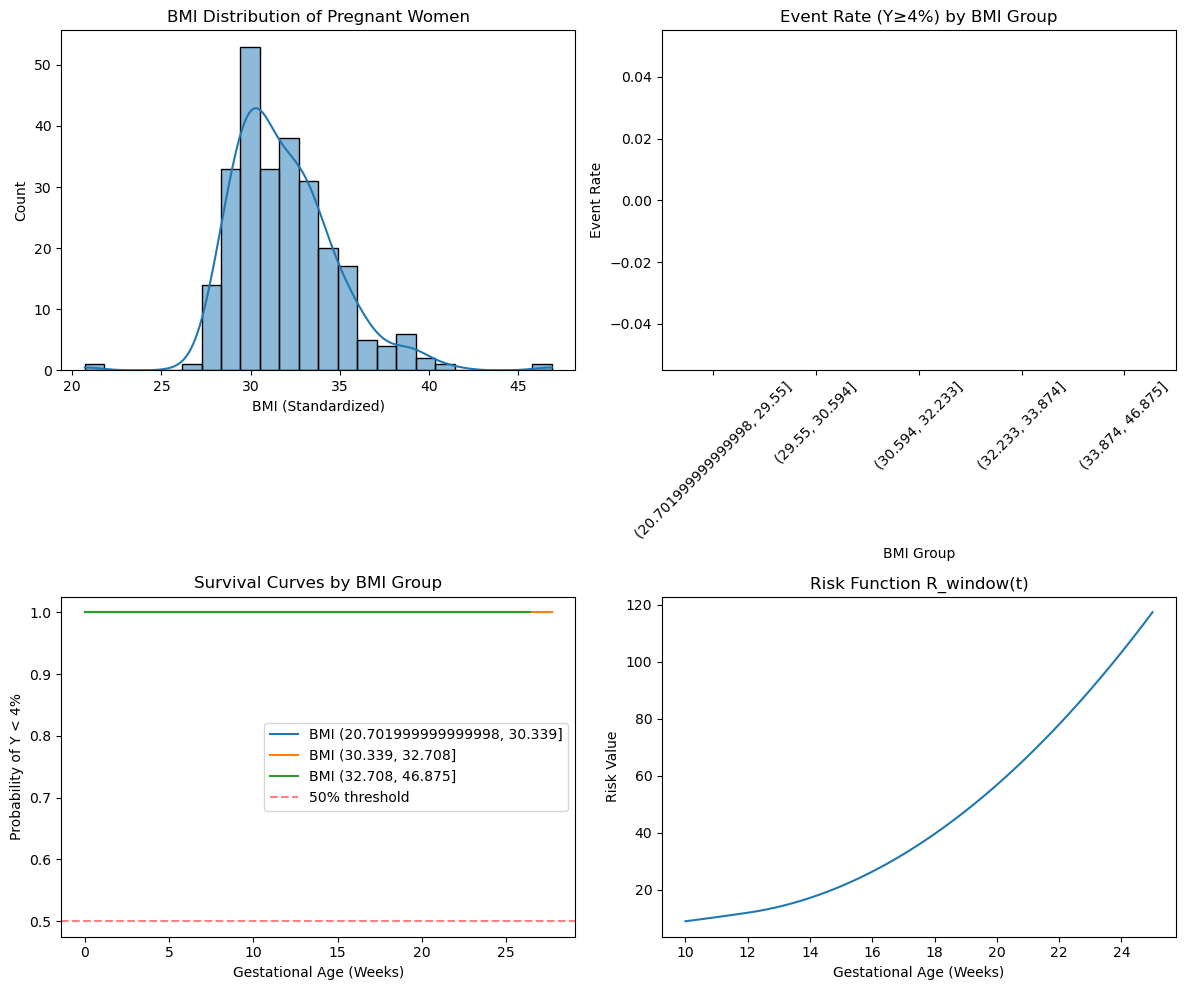

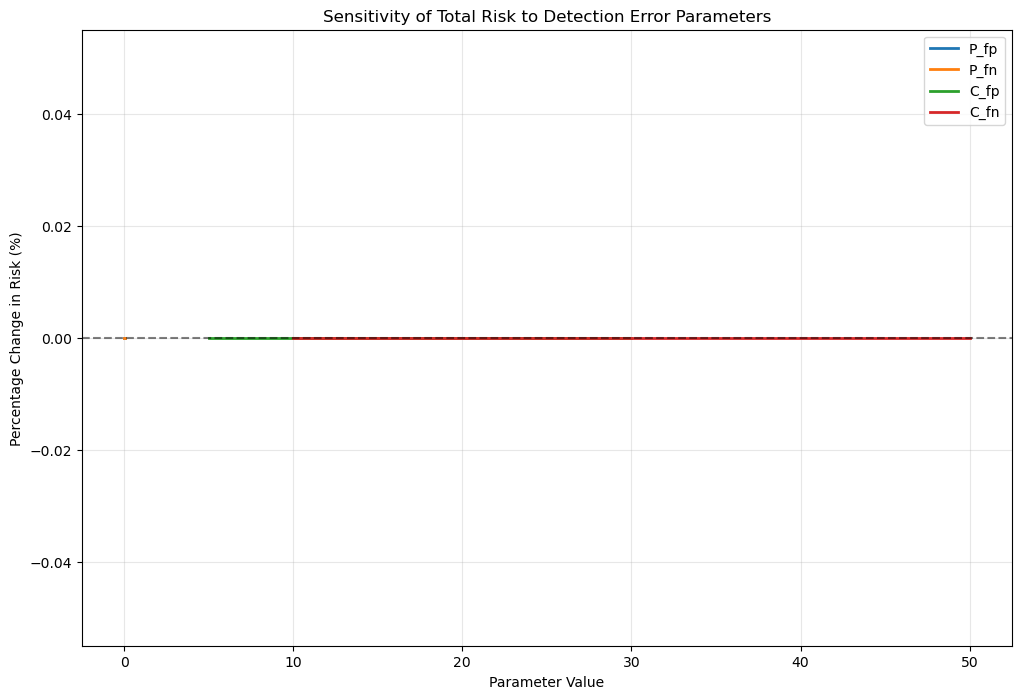

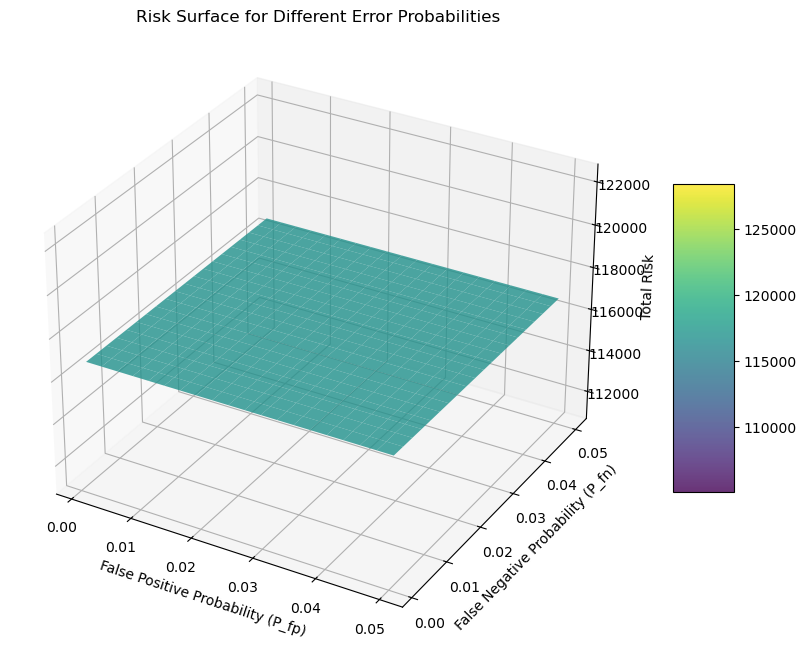

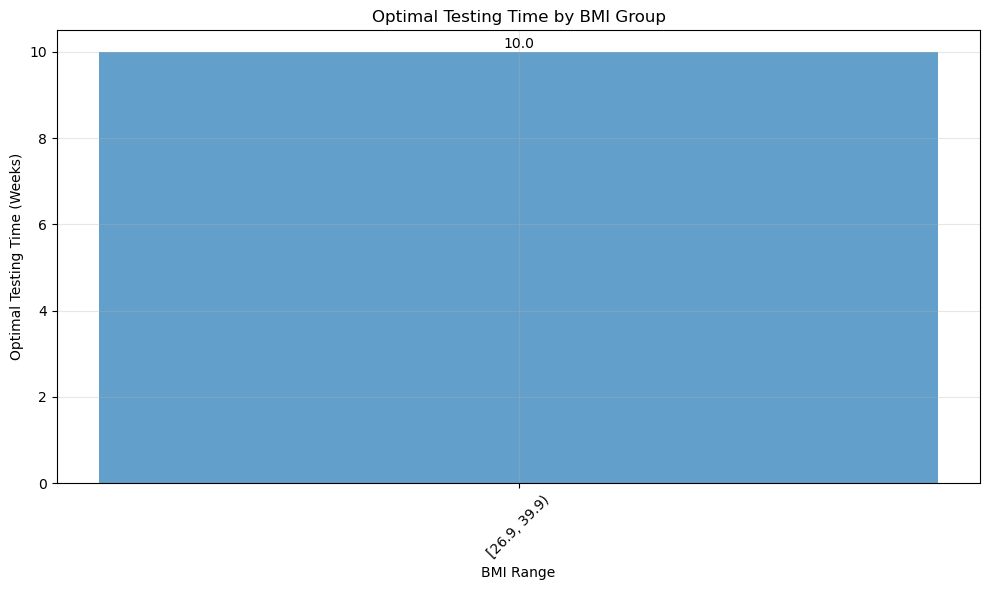

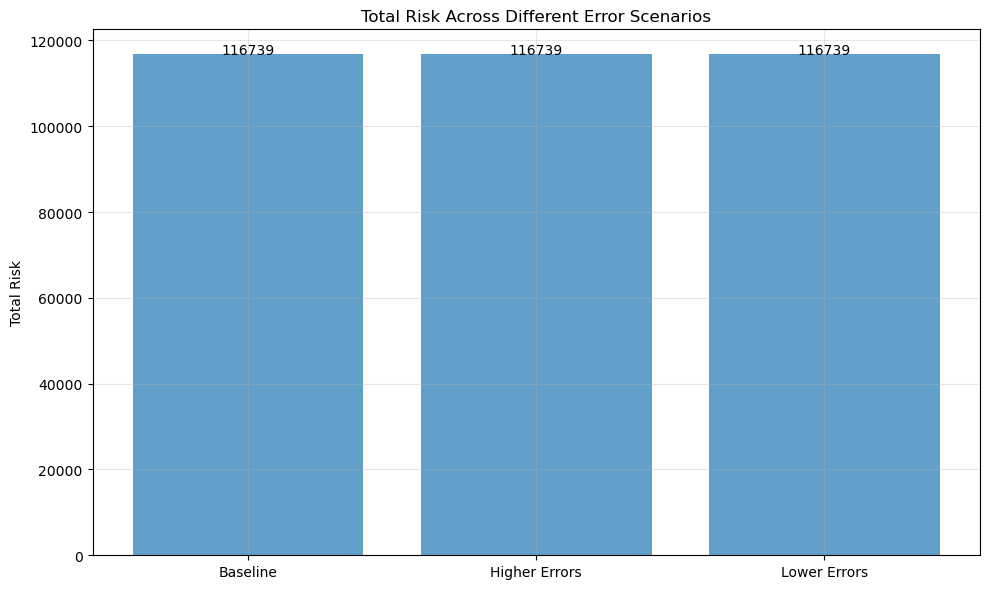

In [3]:

import matplotlib.pyplot as plt  
import seaborn as sns 
from scipy.interpolate import interp1d  


# 2. 风险计算辅助函数
def compute_total_risk(n_groups, best_result, survival_df, P_fp=0.01, P_fn=0.02, C_fp=10, C_fn=20):

    total_risk = 0  # 初始化总风险为0
    # 遍历每组的最佳检测时间，计算每组风险后累加
    for j, test_time in enumerate(best_result['test_times']):
        if test_time is not None:  # 仅处理有有效检测时间的组
            # 1. 提取当前组的样本数据（根据分组边界筛选）
            if n_groups == 1:
                # 1组场景：所有孕妇为同一组
                group_data = survival_df
            else:
                # 多组场景：按边界筛选对应BMI区间的样本
                if j == 0:
                    # 第一组：BMI < 第一个分组边界
                    group_data = survival_df[survival_df['bmi'] < best_result['cutoffs'][0]]
                elif j == n_groups - 1:
                    # 最后一组：BMI ≥ 最后一个分组边界
                    group_data = survival_df[survival_df['bmi'] >= best_result['cutoffs'][-1]]
                else:
                    # 中间组：BMI ≥ 前一个边界且 < 后一个边界（左闭右开，避免重叠）
                    group_data = survival_df[(survival_df['bmi'] >= best_result['cutoffs'][j-1]) & 
                                            (survival_df['bmi'] < best_result['cutoffs'][j])]
            
            # 2. 拟合该组的生存模型（估计未达标概率）
            kmf = KaplanMeierFitter()  # 初始化生存分析模型
            kmf.fit(group_data['time'], group_data['event'])  # 输入孕周（time）和是否达标（event）
            S_t = predict_survival(kmf, test_time)  # 计算该组在最佳检测时间的"未达标概率"（Y<4%的概率）
            
            # 3. 计算该组的风险（单样本风险×样本数）
            # 单样本风险 = 延迟检测风险（R_window） + 检测误差风险（R_test）
            risk_per_woman = R_window(test_time) + R_test(S_t, test_time, P_fp, P_fn, C_fp, C_fn)
            total_risk += len(group_data) * risk_per_woman  # 累加该组总风险
    
    return total_risk  # 返回群体总风险


# 3. 核心可视化模块
# 3.1 创建BMI相关分析的2×2子图
plt.figure(figsize=(12, 10)) 

# 子图1：BMI分布直方图（分析BMI数据的整体分布特征）
plt.subplot(2, 2, 1)  # 位置：第2行第2列的第1个子图
sns.histplot(survival_df['bmi'], kde=True)  # 直方图+核密度曲线（kde=True），展示BMI分布
plt.title('BMI Distribution of Pregnant Women')  # 标题：孕妇BMI分布
plt.xlabel('BMI (Standardized)')  # x轴：BMI值（标准化后，消除量纲影响）
plt.ylabel('Count')  # y轴：样本数量

# 子图2：不同BMI组的事件率（Y≥4%的达标率）柱状图
plt.subplot(2, 2, 2)  # 位置：第2行第2列的第2个子图
bmi_bins = pd.qcut(survival_df['bmi'], q=5, duplicates='drop')  # 将BMI按五分位数分组（5组，避免重叠）
event_rate_by_bmi = survival_df.groupby(bmi_bins)['event'].mean()  # 计算每组的达标率（event=1的比例）
event_rate_by_bmi.plot(kind='bar')  # 绘制柱状图
plt.title('Event Rate (Y≥4%) by BMI Group')  # 标题：不同BMI组的Y染色体达标率
plt.xlabel('BMI Group')  # x轴：BMI分组（如[20.7,25.3)）
plt.ylabel('Event Rate')  # y轴：达标率（0~1）
plt.xticks(rotation=45)  # x轴标签旋转45度，避免重叠

# 子图3：不同BMI组的生存曲线
plt.subplot(2, 2, 3)  # 位置：第2行第2列的第3个子图
bmi_groups = pd.qcut(survival_df['bmi'], q=3, duplicates='drop')  # 将BMI按三分位数分组（3组，兼顾清晰与差异）
for group_name, group_data in survival_df.groupby(bmi_groups):
    kmf = KaplanMeierFitter()  # 为每组单独拟合生存模型
    # 拟合生存曲线：y轴为"未达标概率（Y<4%）"，label标注BMI区间
    kmf.fit(group_data['time'], group_data['event'], label=f'BMI {group_name}')
    kmf.plot(ci_show=False)  # 绘制生存曲线，不显示置信区间（避免图表杂乱）
plt.title('Survival Curves by BMI Group')  # 标题：不同BMI组的生存曲线
plt.xlabel('Gestational Age (Weeks)')  # x轴：孕周（检测时间）
plt.ylabel('Probability of Y < 4%')  # y轴：Y染色体浓度<4%的概率（未达标概率）
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% threshold')  # 红色虚线：50%未达标阈值
plt.legend()  

# 子图4：风险函数R_window(t)曲线
plt.subplot(2, 2, 4)  # 位置：第2行第2列的第4个子图
t_values = np.linspace(10, 25, 100)  # 生成10~25周的连续孕周（100个点，使曲线平滑）
risk_values = [R_window(t) for t in t_values]  # 计算每个孕周的延迟检测风险
plt.plot(t_values, risk_values)  # 绘制风险-孕周曲线
plt.title('Risk Function R_window(t)')  # 标题：延迟检测风险函数
plt.xlabel('Gestational Age (Weeks)')  # x轴：孕周
plt.ylabel('Risk Value')  # y轴：风险值

plt.tight_layout()  # 自动调整子图间距，避免标签重叠
plt.savefig('bmi_analysis.png', dpi=300, bbox_inches='tight') 
plt.show()  # 显示图片


# 3.2 检测误差敏感性分析可视化
if 'best_result' in locals() and best_n > 0:
    # 步骤1：定义误差参数的分析范围（覆盖临床常见的检测精度区间）
    P_fp_range = np.linspace(0.001, 0.05, 20)  # 假阳性率：0.1%~5%
    P_fn_range = np.linspace(0.001, 0.05, 20)  # 假阴性率：0.1%~5%
    C_fp_range = np.linspace(5, 30, 20)       # 假阳性成本：5~30
    C_fn_range = np.linspace(10, 50, 20)      # 假阴性成本：10~50

    # 步骤2：计算基准风险（使用默认误差参数，作为对比基准）
    baseline_params = {'P_fp': 0.01, 'P_fn': 0.02, 'C_fp': 10, 'C_fn': 20}  # 临床常见参数
    baseline_risk = compute_total_risk(best_n, best_result, survival_df, **baseline_params)
    
    # 步骤3：计算每个参数的敏感性（风险随参数变化的百分比）
    sensitivity_results = {}  # 存储敏感性分析结果
    # 遍历每个需分析的参数
    for param_name, param_range in [('P_fp', P_fp_range), ('P_fn', P_fn_range), 
                                   ('C_fp', C_fp_range), ('C_fn', C_fn_range)]:
        risks = []  # 存储该参数不同取值对应的总风险
        for value in param_range:
            # 复制基准参数，仅修改当前分析的参数值
            params = baseline_params.copy()
            params[param_name] = value
            # 计算该参数值下的总风险
            risk = compute_total_risk(best_n, best_result, survival_df, **params)
            risks.append(risk)
        
        # 计算风险变化百分比（敏感性）：(当前风险-基准风险)/基准风险 ×100%
        sensitivity = (np.array(risks) - baseline_risk) / baseline_risk * 100
        # 存储结果（参数值、对应风险、敏感性）
        sensitivity_results[param_name] = {
            'values': param_range,
            'risks': risks,
            'sensitivity': sensitivity
        }
    
    # 步骤4：绘制参数敏感性曲线
    plt.figure(figsize=(12, 8))  
    # 遍历每个参数的敏感性结果，绘制曲线
    for param_name, result in sensitivity_results.items():
        plt.plot(result['values'], result['sensitivity'], label=param_name, linewidth=2)
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # 黑色虚线：风险无变化基准线
    plt.title('Sensitivity of Total Risk to Detection Error Parameters')  # 标题：风险对误差参数的敏感性
    plt.xlabel('Parameter Value')  # x轴：参数值（如假阳性率0.01=1%）
    plt.ylabel('Percentage Change in Risk (%)')  # y轴：风险变化百分比（
    plt.legend()  # 显示图例（区分不同参数）
    plt.grid(True, alpha=0.3)  # 显示网格（便于读取数值）
    plt.savefig('error_sensitivity.png', dpi=300, bbox_inches='tight')  # 保存图片
    plt.show()
    
    # 步骤5：绘制假阳性率（P_fp）与假阴性率（P_fn）的3D风险曲面图
    fig = plt.figure(figsize=(12, 8))  # 创建3D画布
    ax = fig.add_subplot(111, projection='3d')  # 添加3D子图
    
    # 生成参数网格（P_fp为x轴，P_fn为y轴）
    X, Y = np.meshgrid(P_fp_range, P_fn_range)
    Z = np.zeros_like(X)  # 初始化风险矩阵（Z轴为总风险）
    
    # 计算每个(P_fp, P_fn)组合对应的总风险
    for i in range(len(P_fp_range)):
        for j in range(len(P_fn_range)):
            params = baseline_params.copy()
            params['P_fp'] = X[i, j]  # 当前假阳性率
            params['P_fn'] = Y[i, j]  # 当前假阴性率
            Z[i, j] = compute_total_risk(best_n, best_result, survival_df, **params)  # 计算总风险
    
    # 绘制3D曲面图（使用viridis色表，颜色越深风险越高）
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    # 设置坐标轴标签
    ax.set_xlabel('False Positive Probability (P_fp)')  # x轴：假阳性率
    ax.set_ylabel('False Negative Probability (P_fn)')  # y轴：假阴性率
    ax.set_zlabel('Total Risk')  # z轴：总风险
    ax.set_title('Risk Surface for Different Error Probabilities')  # 标题：不同误差概率的风险曲面
    fig.colorbar(surf, shrink=0.5, aspect=5)  # 添加颜色条（解释颜色与风险的对应关系）
    plt.savefig('error_surface.png', dpi=300, bbox_inches='tight')  
    plt.show()


# 3. 按BMI分组的最佳检测时间可视化
# 仅当存在最优分组结果（best_result）且分组数>0时执行
if 'best_result' in locals() and best_n > 0:
    plt.figure(figsize=(10, 6))  
    
    # 步骤1：生成BMI分组的文字描述（如"[20.7,39.6)"）和分组中点
    if best_n == 1:
        # 1组场景（不分组）：BMI范围简化为"All"，中点用整体BMI中位数
        bmi_ranges = ["All"]
        bmi_midpoints = [survival_df['bmi'].median()]
    else:
        bmi_ranges = []  # 存储每组BMI的文字范围
        bmi_midpoints = []  # 存储每组BMI的中点
        cutoffs = best_result['cutoffs']  # 最优分组的BMI边界（如[39.64]）
        min_bmi = survival_df['bmi'].min()  # 整体BMI最小值
        max_bmi = survival_df['bmi'].max()  # 整体BMI最大值
        
        # 第一组：[最小BMI, 第一个边界)（左闭右开，避免分组重叠）
        bmi_ranges.append(f"[{min_bmi:.1f}, {cutoffs[0]:.1f})")
        bmi_midpoints.append((min_bmi + cutoffs[0]) / 2)  # 计算中点（反映组内BMI平均水平）
        
        # 中间组：[前一个边界, 后一个边界)（遍历所有中间边界）
        for i in range(len(cutoffs)-1):
            bmi_ranges.append(f"[{cutoffs[i]:.1f}, {cutoffs[i+1]:.1f})")
            bmi_midpoints.append((cutoffs[i] + cutoffs[i+1]) / 2)
        
        # 最后一组：[最后一个边界, 最大BMI]（右闭，确保覆盖所有高BMI样本）
        bmi_ranges.append(f"[{cutoffs[-1]:.1f}, {max_bmi:.1f}]")
        bmi_midpoints.append((cutoffs[-1] + max_bmi) / 2)
    
    # 步骤2：过滤无效的检测时间（排除None值，避免绘图报错）
    # 生成有效检测时间的索引（仅保留test_time不为None的组）
    valid_indices = [i for i, t in enumerate(best_result['test_times']) if t is not None]
    valid_times = [best_result['test_times'][i] for i in valid_indices]  # 有效检测时间列表
    valid_ranges = [bmi_ranges[i] for i in valid_indices]  # 对应有效组的BMI范围
    
    # 步骤3：绘制柱状图（仅当有有效数据时）
    if valid_times:  # 避免无有效数据时绘图失败
        # 绘制柱状图：x轴为BMI组，y轴为最佳检测时间，透明度0.7（避免颜色过深刺眼）
        plt.bar(range(len(valid_times)), valid_times, tick_label=valid_ranges, alpha=0.7)
        plt.title('Optimal Testing Time by BMI Group')  # 标题：按BMI分组的最佳检测时间
        plt.xlabel('BMI Range')  # x轴：BMI分组
        plt.ylabel('Optimal Testing Time (Weeks)')  # y轴：最佳检测时间
        plt.xticks(rotation=45)  # x轴标签旋转45度，避免长范围文字重叠（如"[20.7,39.6)"）
        plt.grid(True, alpha=0.3)  # 显示网格线（透明度0.3，便于读取具体数值，不干扰图表主体）
        
        # 步骤4：在柱子顶部添加数值标签（直观展示具体推荐时间，无需医生估读）
        for i, v in enumerate(valid_times):
            # 文字位置：x=i（柱子中心），y=v+0.1（柱子顶部上方0.1单位，避免重叠）
            # 文字内容：保留1位小数（临床精度足够，如12.3周），水平居中（ha='center'）
            plt.text(i, v + 0.1, f'{v:.1f}', ha='center')
        
        plt.tight_layout()  # 自动调整布局，确保x轴标签不被截断（如旋转后的文字）
        plt.savefig('optimal_times.png', dpi=300, bbox_inches='tight') 
        plt.show()  # 显示图表
    else:
        # 无有效数据时提示（便于调试，避免静默失败）
        print("No valid test times available for plotting")



plt.figure(figsize=(10, 6))  
# 定义误差场景的文字名称
scenario_names = ['Baseline', 'Higher Errors', 'Lower Errors']
risk_values = []  # 存储每个场景的总风险

# 步骤1：计算每个误差场景的总风险
for i, params in enumerate(error_scenarios):
    # 调用之前定义的compute_total_risk函数，计算当前场景的总风险
    risk = compute_total_risk(best_n, best_result, survival_df, **params)
    risk_values.append(risk)  # 加入风险列表

# 步骤2：绘制风险对比柱状图
plt.bar(scenario_names, risk_values, alpha=0.7)  # x轴为场景名称，y轴为总风险，透明度0.7
plt.title('Total Risk Across Different Error Scenarios')  # 标题：不同误差场景的总风险对比
plt.ylabel('Total Risk')  # y轴：总风险（量化临床危害，数值越低越好）
plt.grid(True, alpha=0.3)  # 显示网格线，便于对比风险差异

# 步骤3：在柱子顶部添加数值标签（直观展示风险差异，支持临床决策）
for i, v in enumerate(risk_values):
    # 文字位置：y=v+100（根据风险数值范围调整，避免与柱子重叠，此处假设风险约1e5量级）
    # 文字内容：保留0位小数（风险为整数更易对比，如116739），水平居中
    plt.text(i, v + 100, f'{v:.0f}', ha='center')

plt.tight_layout()  
plt.savefig('risk_comparison.png', dpi=300, bbox_inches='tight')  
plt.show()  



In [4]:
print(male_data[['Gestational_Week_Decimal', 'Concentration of Chromosome Y']].isna().sum())

Gestational_Week_Decimal         52
Concentration of Chromosome Y     0
dtype: int64


In [5]:
print("Unique women in male_data:", male_data['Pregnant Woman Code'].nunique())
print("Women with non-NaN values:", male_data.dropna(subset=['Gestational_Week_Decimal', 'Concentration of Chromosome Y'])['Pregnant Woman Code'].nunique())

Unique women in male_data: 267
Women with non-NaN values: 260


In [6]:
print("BMI data type:", survival_df['bmi'].dtype)
print("Sample BMI values:", survival_df['bmi'].head().values)

BMI data type: float64
Sample BMI values: [28.125      33.3318319  30.7421875  28.64124339 29.95555556]


In [7]:
# survival_data

In [8]:
# survival_data['bmi']

In [9]:
survival_df['bmi']

0      28.125000
1      33.331832
2      30.742188
3      28.641243
4      29.955556
         ...    
255    29.346687
256    32.471062
257    33.719678
258    32.135095
259    30.703133
Name: bmi, Length: 260, dtype: float64

In [10]:
# survival_data['bmi'].min()